In [29]:
import requests as rq
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from TCGA_files import get_tcga_tissue
#from ensembleAPI import geneinfo, genesinfo
from sklearn import metrics
from hsbmpy import *
import os

In [ ]:
import importlib, hsbmpy
importlib.reload(hsbmpy)
from hsbmpy import *

## query many

In [30]:
level = 1
algorithm = 'topsbm'
directory = "/home/jovyan/work/phd/datasets/gtex/10/"
L=get_max_available_L(directory, algorithm)
df_clusters = pd.read_csv("%s/%s/%s_level_%d_clusters.csv"%(directory,algorithm,algorithm,L), header=[0])
df_clusters.head()

,Cluster 1
0,GTEX-RM2N-0526-SM-2TF4N
1,GTEX-14ASI-1126-SM-5QGPN
2,GTEX-1QW4Y-1926-SM-E8VO3
3,GTEX-ZAB5-2026-SM-5L3EQ
4,GTEX-OIZG-0426-SM-3LK5W


In [31]:
#df_files = pd.read_csv("https://storage.googleapis.com/gtex_analysis_v8/annotations/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt", sep='\t')
#df_files.set_index('SAMPID', inplace=True)
#df_files.dropna(how='all', axis=0).to_csv("%s/files.dat"%directory, index=True, header=True)

In [32]:
df_files = pd.read_csv("%s/files.dat"%directory, index_col=[0], header=[0]).dropna(axis=1, how='all').dropna(axis=0, how='all')
samples = pd.read_csv("%s/%s/%s_level_0_clusters.csv"%(directory,algorithm,algorithm), header=[0]).astype(str).values.ravel()
samples=samples[samples!="nan"]
df_files = df_files.reindex(index=samples).dropna(how="all", axis=0)
labels = df_files.columns
labels

Index(['SMATSSCR', 'SMCENTER', 'SMPTHNTS', 'SMRIN', 'SMTS', 'SMTSD', 'SMUBRID',
       'SMTSISCH', 'SMTSPAX', 'SMNABTCH', 'SMNABTCHT', 'SMNABTCHD', 'SMGEBTCH',
       'SMGEBTCHD', 'SMGEBTCHT', 'SMAFRZE', 'SMGTC', 'SME2MPRT', 'SMCHMPRS',
       'SMNTRART', 'SMMAPRT', 'SMEXNCRT', 'SMGNSDTC', 'SMUNMPRT', 'SMRDLGTH',
       'SME1MMRT', 'SMSFLGTH', 'SMESTLBS', 'SMMPPD', 'SMNTERRT', 'SMRRNANM',
       'SMRDTTL', 'SMVQCFL', 'SMTRSCPT', 'SMMPPDPR', 'SMUNPDRD', 'SMNTRNRT',
       'SMMPUNRT', 'SMEXPEFF', 'SMMPPDUN', 'SME2MMRT', 'SME2ANTI', 'SMALTALG',
       'SME2SNSE', 'SMMFLGTH', 'SME1ANTI', 'SMSPLTRD', 'SMBSMMRT', 'SME1SNSE',
       'SME1PCTS', 'SMRRNART', 'SME1MPRT', 'SMDPMPRT', 'SME2PCTS'],
      dtype='object')

In [ ]:
df_files["dataset_status"]=df_files["dataset"]+"_"+df_files["status"]
labels=["dataset_status"]

In [ ]:
df_files["Subtype_Selected"].unique()

In [33]:
labels=['primary_site', 'disease_type']
#labels = ['subtype', 'pathologic_stage', 'vital_status','days_to_death_binned']
labels = ['primary_site', 'disease_type', 'primary_diagnosis', 
       'methylation_subtype', 'expression_subtype',
       'hypermutated', 'cancer',
       'anatomic_organ_subdivision', 'tumor_site',
       'age_at_initial_pathologic_diagnosis', 'days_to_death',
       'distant_metastasis_pathologic_spread', 'gender', 'histological_type',
       'history_of_colon_polyps',     'lymphatic_invasion_present', 'lymphnode_pathologic_spread',
       'person_neoplasm_cancer_status', 'preoperative_pretreatment_cea_level',
       'primary_tumor_pathologic_spread', 'prior_diagnosis', 'residual_tumor',
       'synchronous_colon_cancer_present', 'tumor_stage',
       'vascular_invasion_present', 'vital_status'] #crectal

#labels = ['cases.0.diagnoses.0.morphology',
#       'cases.0.diagnoses.0.primary_diagnosis',
#       'cases.0.diagnoses.0.tissue_or_organ_of_origin',
#       'cases.0.diagnoses.0.tumor_grade', 'cases.0.diagnoses.0.tumor_stage',
#       'cases.0.project.disease_type', 'cases.0.project.primary_site',
#       'cases.0.samples.0.longest_dimension'] #lung

labels = ["Survival(days)", 'Sample_characteristics_ch0', 'Sample_characteristics_ch1',
       'Sample_characteristics_ch2', 'Sample_characteristics_ch3',
       'Sample_characteristics_ch4', 'Sample_characteristics_ch5',
       'Sample_characteristics_ch6', 'Sample_characteristics_ch7',
       'Sample_characteristics_ch8', 'Sample_growth_protocol_ch1']# pancreas
labels = ['cancer.type', "Subtype_Selected"]
labels=['SMTS', "SMTSD"]
#labels=["Type", "Subtype"]
#labels = ["primary_site", "tissue_hd"]

In [ ]:
labels = ['cases.0.diagnoses.0.tumor_grade', 'cases.0.diagnoses.0.tumor_stage',
         'cases.0.diagnoses.0.primary_diagnosis']

In [ ]:
for normalise in [True, False]:
    for label in labels:
        for level in np.arange(L+1)[::-1]:
            if level==0:
                #pass
                continue
            print(normalise, label, level)
            try:
                cluster = get_cluster_given_l(level, directory,algorithm=algorithm)
                fraction_sites = get_fraction_sites(cluster,df_files=df_files,label=label, normalise=normalise)

                clustersinfo = get_clustersinfo(cluster,fraction_sites)
                plot_cluster_composition(fraction_sites,directory,level,label=label, normalise=normalise,algorithm=algorithm)
                make_heatmap(fraction_sites, directory, label, level, normalise=normalise,algorithm=algorithm)

                clustersinfo = get_clustersinfo(cluster,fraction_sites)            
                if not normalise:
                    plot_maximum(clustersinfo,cluster,label,level, directory,algorithm=algorithm)
                    plot_maximum_size(clustersinfo,label,level, directory,algorithm=algorithm)
                    plot_maximum_label(clustersinfo,label,level, directory,algorithm=algorithm)
                    plot_sizes(level,directory, algorithm=algorithm)
            except:
                print(*sys.exc_info())
            shuffle_files(df_files,label).to_csv("%s/files_shuffles.dat"%directory, index=True)
            fraction_sites_shuffle = get_fraction_sites(cluster, df_files=pd.read_csv("%s/files_shuffles.dat"%directory, index_col=[0]),label=label, normalise=normalise)
            clustersinfo_shuffle = get_clustersinfo(cluster, fraction_sites_shuffle)
            plot_cluster_composition(fraction_sites_shuffle,directory,level, label=label, shuffled=True, normalise=normalise, algorithm=algorithm)
            if not normalise:
                plot_maximum(clustersinfo,cluster,label,level,directory,clustersinfo_shuffle,algorithm=algorithm)
                plot_maximum_size(clustersinfo,label,level, directory,clustersinfo_shuffle,algorithm=algorithm)
                plot_maximum_label(clustersinfo,label,level, directory,clustersinfo_shuffle,algorithm=algorithm)
                plot_labels_size(clustersinfo,label,level, directory,clustersinfo_shuffle,algorithm=algorithm)

In [28]:
##useful for R clustree plot
def reindex(x):
    i=0
    last=x[0]
    new = []
    for xi in x:
        if xi == last:
            pass
        else:
            i+=1
            last=xi
        new.append(i)
    return new

df_labels = pd.DataFrame()
shape = df_clusters.dropna().shape
files = pd.read_csv("%s/%s/%s_level_1_clusters.csv"%(directory,algorithm,algorithm), header=[0]).astype(str).values.ravel()
files = files[files!="nan"]

for level in np.arange(L+1)[::-1]:
    df_clusters = pd.read_csv("%s/%s/%s_level_%d_clusters.csv"%(directory,algorithm,algorithm,level), header=[0])
    print("level ", level, "with ", df_clusters.shape[1], " clusters")
    currentlevellabels = []
    for file in files:
        s = df_clusters[df_clusters.isin([file])].any(0)
        a = s.index[s]
        currentlevellabels.append(int(a[0][8:])-1)
    df_labels.insert(0,'l%d'%level,currentlevellabels)
    del currentlevellabels
filelabels = []
filesublabels = []
for file in files:
    try:
        filelabels.append(get_file(file, df_files)[labels[0]])
        filesublabels.append(get_file(file, df_files)[labels[1]])
    except:
        filelabels.append('unknown')
        filesublabels.append('unknown')
        print(*sys.exc_info())
df_labels.insert(0,'tissue', filelabels)
df_labels.insert(0,'subtissue', filesublabels)
df_labels.sort_values(by=['tissue','subtissue'], inplace=True)
df_labels.sort_values(by=["l%d"%l for l in np.arange(L+1)[::-1]], axis=0, inplace=True)
filelabels = df_labels['tissue']
filesublabels = df_labels['subtissue']
df_labels = df_labels.apply(reindex, axis=0)
df_labels['tissue']=filelabels
df_labels['subtissue']=filesublabels
df_labels.to_csv("%s/%s/topsbm_labels.csv"%(directory,algorithm), index=False, header=True)

level  3 with  2  clusters
level  2 with  2  clusters
level  1 with  5  clusters
level  0 with  65  clusters


In [10]:
if "clustersizes.txt" in os.listdir(directory):
    with open("%s/clustersizes.txt"%directory, 'r') as f:
        xl=np.array(f.read().split()).astype(int)
else:
    try:
        xl = getclustersizesarray(directory, L)
        with open("%s/clustersizes.txt" % directory, 'w') as f:
            for x in xl:
                f.write("%d\n" % x)
    except:
        print(*sys.exc_info())
        print("cannot save clustersizes.txt")

if "topicsizes.txt" in os.listdir(directory):
    with open("%s/topicsizes.txt"%directory) as f:
        tl=np.array(f.read().split()).astype(int)
else:
    try:
        tl = gettopicsizesarray(directory, L)
        with open("%s/topicsizes.txt" % directory, 'w') as f:
            for x in tl:
                f.write("%d\n" % x)
    except:
        print("cannot save topicsizes.txt")

In [ ]:
scores = get_scores(directory, labels, verbose=False)
scores['hsbm'] = scores[labels[0]]

In [ ]:
fig=plt.figure(figsize=(18,15))
ax = fig.subplots(1)
add_score_lines(ax,scores,labels, alpha=1)
ax.set_xscale('log')
ax.set_ylim(0,1)

plt.show()
fig.savefig("%s/metric_scores_hierstructure.pdf"%(directory))

In [ ]:
fig=plt.figure(figsize=(18,15))
ax = fig.subplots(1)
#add_score_lines(ax,scores,[labels[0]],xl, h=True, c=True, alpha=1)
h = np.array(scores['hsbm']['h'])
c = np.array(scores['hsbm']['c'])
ax.plot(scores['hsbm']['xl'],h, marker='o', ls='--', lw=10, ms=40, label='homogeneity')
ax.plot(scores['hsbm']['xl'],c, marker='o', ls='-.', lw=10,ms=40, label='completeness')
ax.plot(scores['hsbm']['xl'],scores['hsbm']['V'], marker='o', ms=40, ls='-', lw=10, label='score')
ax.set_xscale('log')
ax.set_ylim(0,1)
#ax.plot(xl, 2*h*c/(h+c), ls='-',c='g')
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.legend(fontsize=35)

ax.tick_params(labelsize=35, width=8, length=20)
ax.tick_params(which="minor", labelsize=35, width=5, length=15)

plt.xlabel('number of clusters', fontsize=35)
plt.ylabel('measure', fontsize=35)
plt.show()
fig.savefig("%s/metric_scores_primarysite.pdf"%(directory))

In [35]:
label = "SMTS"
scores = {}
scores['hsbm'] = get_scores(directory, labels, df_files=df_files, verbose=False)[label]
scores['hierarchical'] = get_scores(directory, labels, algorithm='hierarchical-log', verbose=False)[label]
scores['lda'] = get_scores(directory, labels, algorithm='lda', verbose=False)[label]
#scores['kmeans'] = get_scores(directory, labels, algorithm='kmeans', verbose=False)[label]
scores['tm']=get_scores(directory, labels, algorithm='tm', verbose=False)[label]
#scores['cc']=get_scores(directory, labels, algorithm='cc', verbose=False)[label]
scores['wgcna']=get_scores(directory, labels, algorithm='wgcna', verbose=False)[label]
scores['shuffle'] = get_scores_shuffled(directory, df_files, label=label, algorithm='topsbm')

/home/jovyan/work/phd/hsbmpy.py:624: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  np.random.shuffle(df_files_shuffled[label])


In [ ]:
label="SMTS"
scores={}
#scores['hierarchical'] = get_scores(directory, labels, algorithm='hierarchical-log', verbose=False)[label]
#scores['lda-tpm'] = get_scores(directory, labels, algorithm='lda-tpm', verbose=False)[label]
scores['hsbm-log2'] = get_scores(directory, labels, algorithm='topsbm-log', verbose=False)[label]
scores['hsbm-log10'] = get_scores(directory, labels, algorithm='topsbm-log10', verbose=False)[label]
scores['hsbm'] = get_scores(directory, labels, algorithm='topsbm', df_files=df_files, verbose=False)[label]
scores['hsbm-sweep'] = get_scores(directory, labels, algorithm='topsbm-sweep', df_files=df_files, verbose=False)[label]
scores['shuffle'] = get_scores_shuffled(directory, df_files, label=label, algorithm='topsbm')

In [ ]:
scores["tissues"] = get_scores(directory, labels, algorithm='topsbm-log', verbose=False)["SMTS"]
scores["sub_tissues"] = get_scores(directory, labels, algorithm='topsbm-log', verbose=False)["SMTSD"]

In [ ]:
from hsbmpy import normalise_score
normalise_score(scores, base_algorithm="hsbm")

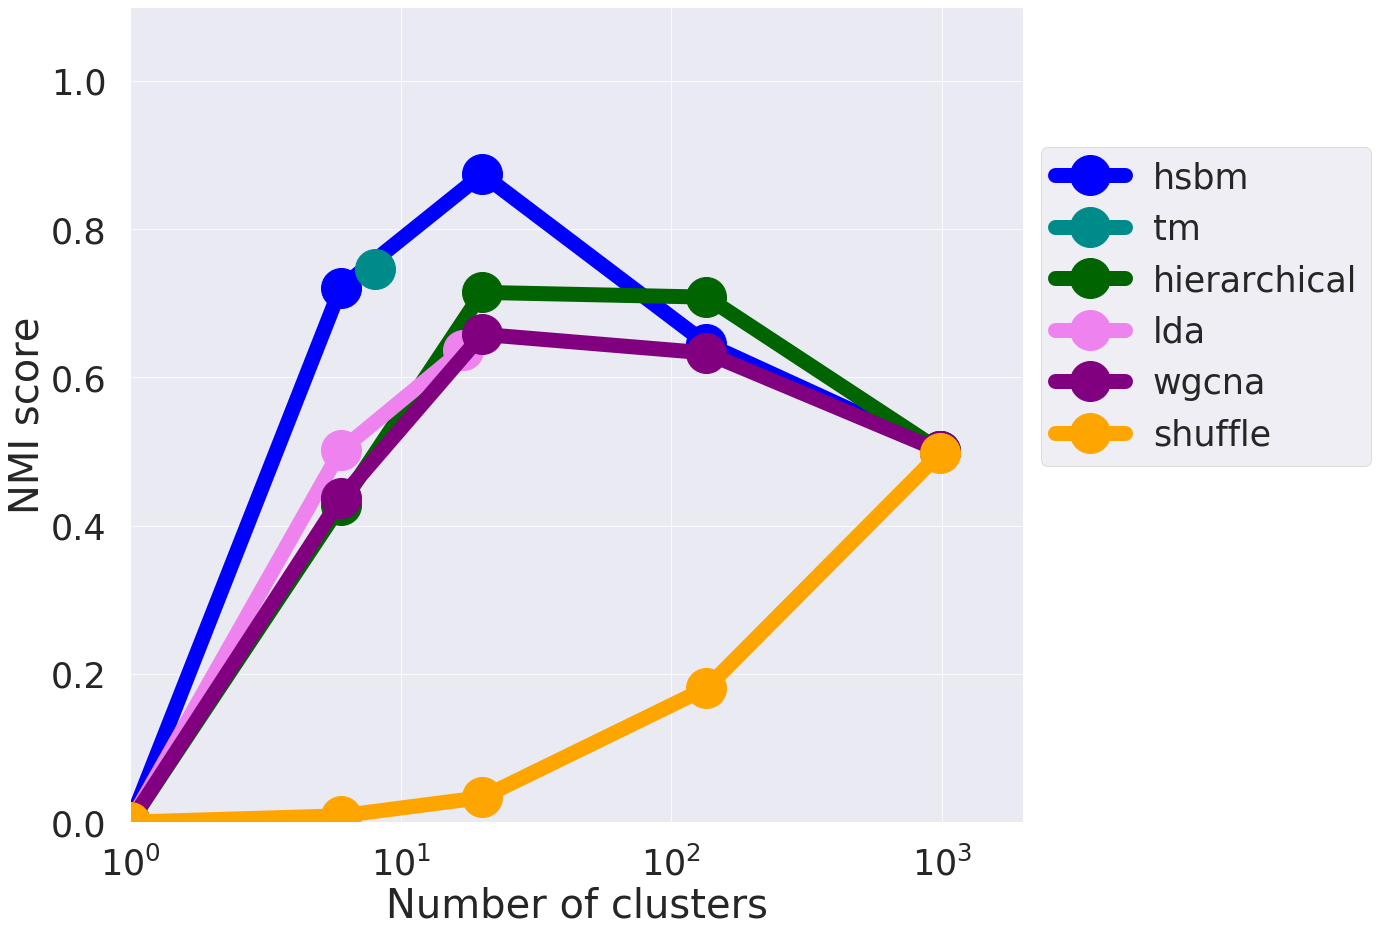

In [36]:
fig=plt.figure(figsize=(20,15))
ax = fig.subplots(1)
add_score_lines(ax,scores,labels=['hsbm', 'tm', 'hierarchical', 'lda', 'wgcna', 'shuffle'])
#add_score_lines(ax,scores,labels=["tissues", "sub_tissues",'shuffle'])
#add_score_lines(ax,scores,labels=["hsbm", "hsbm-sweep", "hsbm-log2","hsbm-log10",'shuffle'])
#ax.set_xscale('linear')
plt.xlim(1,2000)
plt.show()
fig.savefig("%s/metric_scores_all.pdf"%(directory))